# Seed Analysis

In [1]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification,
    AutoTokenizer, AutoModel, AutoConfig,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    get_linear_schedule_with_warmup
)
from datasets import load_dataset, Dataset as HFDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import logging
import os
import json
import warnings
from typing import Dict, List, Tuple, Optional
from datetime import datetime
import joblib
import random
from collections import Counter
import gc

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create output directories
os.makedirs("./random_seed_analysis_results", exist_ok=True)
os.makedirs("./trained_models_seeds", exist_ok=True)

print("✅ Libraries imported and setup complete!")

c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
✅ Libraries imported and setup complete!


In [2]:
# Cell 2: Utility Functions for Memory Management
def set_random_seed(seed: int):
    """Set random seed for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def clear_memory():
    """Clear GPU memory"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

def print_memory_usage():
    """Print current GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        cached = torch.cuda.memory_reserved() / 1024**3
        print(f"GPU Memory - Allocated: {allocated:.2f} GB, Cached: {cached:.2f} GB")

print("✅ Utility functions defined!")

✅ Utility functions defined!


In [16]:
# Cell 3: Data Loading and Preprocessing Functions
def load_external_datasets() -> Tuple[Dict, Dict]:
    """Load SST-2 and GoEmotions datasets"""
    print("Loading external datasets...")
    
    # Load SST-2 for sentiment
    try:
        sst2_dataset = load_dataset("sst2")
        sentiment_data = {
            'train': sst2_dataset['train'],
            'validation': sst2_dataset['validation']
        }
        print(f"✅ SST-2 dataset loaded: {len(sentiment_data['train'])} train samples")
    except Exception as e:
        print(f"❌ Could not load SST-2: {e}")
        raise
    
    # Load GoEmotions for emotion
    try:
        emotions_dataset = load_dataset("go_emotions", "simplified")
        emotion_data = {
            'train': emotions_dataset['train'],
            'validation': emotions_dataset['validation']
        }
        print(f"✅ GoEmotions dataset loaded: {len(emotion_data['train'])} train samples")
    except Exception as e:
        print(f"❌ Could not load GoEmotions: {e}")
        raise
    
    return sentiment_data, emotion_data

def prepare_reddit_evaluation_data(reddit_data_path: str) -> Dict:
    """Load and prepare Reddit data for evaluation"""
    print(f"Loading Reddit evaluation data from {reddit_data_path}...")
    
    df = pd.read_csv(reddit_data_path)
    
    # Create label encoders that match your existing models
    sentiment_encoder = LabelEncoder()
    emotion_encoder = LabelEncoder()
    
    # Fit encoders
    sentiment_encoder.fit(df['sentiment'].tolist())
    emotion_encoder.fit(df['emotion'].tolist())
    
    reddit_data = {
        'texts': df['text_content'].tolist(),
        'sentiment_labels_text': df['sentiment'].tolist(),
        'emotion_labels_text': df['emotion'].tolist(),
        'sentiment_labels': sentiment_encoder.transform(df['sentiment'].tolist()),
        'emotion_labels': emotion_encoder.transform(df['emotion'].tolist()),
        'sentiment_encoder': sentiment_encoder,
        'emotion_encoder': emotion_encoder
    }
    
    print(f"✅ Reddit data prepared: {len(reddit_data['texts'])} samples")
    print(f"   Sentiment classes: {list(sentiment_encoder.classes_)}")
    print(f"   Emotion classes: {list(emotion_encoder.classes_)}")
    
    return reddit_data

print("✅ Data loading functions defined!")

✅ Data loading functions defined!


In [4]:
# Cell 4: Dataset Classes
class RobertaDataset(Dataset):
    def __init__(self, texts: List[str], labels: List[int], tokenizer, max_length: int = 512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

class MultiTaskDataset(Dataset):
    def __init__(self, texts: List[str], sentiment_labels: List[int], 
                 emotion_labels: List[int], tokenizer, max_length: int = 128):
        self.texts = texts
        self.sentiment_labels = sentiment_labels
        self.emotion_labels = emotion_labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        sentiment_label = self.sentiment_labels[idx]
        emotion_label = self.emotion_labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'sentiment_labels': torch.tensor(sentiment_label, dtype=torch.long),
            'emotion_labels': torch.tensor(emotion_label, dtype=torch.long)
        }

print("✅ Dataset classes defined!")

✅ Dataset classes defined!


In [5]:
# Cell 5: Multitask Model Architecture (Same as your stad-valid.ipynb)
class MultiTaskTransformer(nn.Module):
    def __init__(
        self,
        model_name: str = "microsoft/deberta-base",
        sentiment_num_classes: int = 3,
        emotion_num_classes: int = 6,
        hidden_dropout_prob: float = 0.1,
        attention_dropout_prob: float = 0.1,
        classifier_dropout: float = 0.1
    ):
        super(MultiTaskTransformer, self).__init__()
        
        self.model_name = model_name
        self.sentiment_num_classes = sentiment_num_classes
        self.emotion_num_classes = emotion_num_classes
        
        # Load configuration and adjust dropout
        config = AutoConfig.from_pretrained(model_name)
        config.hidden_dropout_prob = hidden_dropout_prob
        config.attention_probs_dropout_prob = attention_dropout_prob
        
        # Shared transformer encoder
        self.shared_encoder = AutoModel.from_pretrained(
            model_name,
            config=config,
            ignore_mismatched_sizes=True
        )
        
        hidden_size = self.shared_encoder.config.hidden_size
        
        # Task-specific attention layers
        self.sentiment_attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=8,
            dropout=attention_dropout_prob,
            batch_first=True
        )
        
        self.emotion_attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=8,
            dropout=attention_dropout_prob,
            batch_first=True
        )
        
        # Shared attention for common features
        self.shared_attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=8,
            dropout=attention_dropout_prob,
            batch_first=True
        )
        
        # Layer normalization
        self.sentiment_norm = nn.LayerNorm(hidden_size)
        self.emotion_norm = nn.LayerNorm(hidden_size)
        self.shared_norm = nn.LayerNorm(hidden_size)
        
        # Dropout layers
        self.sentiment_dropout = nn.Dropout(classifier_dropout)
        self.emotion_dropout = nn.Dropout(classifier_dropout)
        self.shared_dropout = nn.Dropout(classifier_dropout)
        
        # Classification heads
        self.sentiment_classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(classifier_dropout),
            nn.Linear(hidden_size, sentiment_num_classes)
        )
        
        self.emotion_classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(classifier_dropout),
            nn.Linear(hidden_size, emotion_num_classes)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for module in [self.sentiment_classifier, self.emotion_classifier]:
            for layer in module:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    nn.init.zeros_(layer.bias)
    
    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor, 
                task: Optional[str] = None) -> Dict[str, torch.Tensor]:
        # Shared encoder
        encoder_outputs = self.shared_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        
        sequence_output = encoder_outputs.last_hidden_state
        
        # Apply shared attention
        shared_attended, _ = self.shared_attention(
            sequence_output, sequence_output, sequence_output,
            key_padding_mask=~attention_mask.bool()
        )
        shared_attended = self.shared_norm(shared_attended + sequence_output)
        shared_attended = self.shared_dropout(shared_attended)
        shared_pooled = shared_attended[:, 0, :]
        
        outputs = {}
        
        # Sentiment branch
        if task is None or task == "sentiment":
            sentiment_attended, sentiment_weights = self.sentiment_attention(
                sequence_output, sequence_output, sequence_output,
                key_padding_mask=~attention_mask.bool()
            )
            sentiment_attended = self.sentiment_norm(sentiment_attended + sequence_output)
            sentiment_attended = self.sentiment_dropout(sentiment_attended)
            sentiment_pooled = sentiment_attended[:, 0, :]
            sentiment_features = torch.cat([shared_pooled, sentiment_pooled], dim=-1)
            sentiment_logits = self.sentiment_classifier(sentiment_features)
            outputs["sentiment_logits"] = sentiment_logits
        
        # Emotion branch
        if task is None or task == "emotion":
            emotion_attended, emotion_weights = self.emotion_attention(
                sequence_output, sequence_output, sequence_output,
                key_padding_mask=~attention_mask.bool()
            )
            emotion_attended = self.emotion_norm(emotion_attended + sequence_output)
            emotion_attended = self.emotion_dropout(emotion_attended)
            emotion_pooled = emotion_attended[:, 0, :]
            emotion_features = torch.cat([shared_pooled, emotion_pooled], dim=-1)
            emotion_logits = self.emotion_classifier(emotion_features)
            outputs["emotion_logits"] = emotion_logits
        
        return outputs

print("✅ Multitask model architecture defined!")

✅ Multitask model architecture defined!


In [6]:
# Cell 6: Training Functions for Single-Task Models
def train_roberta_single_task(
    task_type: str,  # 'sentiment' or 'emotion'
    best_params: Dict,
    seed: int,
    sentiment_data: Dict = None,
    emotion_data: Dict = None,
    max_samples: int = 10000
) -> Tuple[any, LabelEncoder]:
    """Train a single-task RoBERTa model"""
    
    print(f"🚀 Training RoBERTa {task_type} model with seed {seed}")
    set_random_seed(seed)
    clear_memory()
    
    # Load appropriate dataset
    if task_type == 'sentiment':
        raw_data = sentiment_data
        text_col = 'sentence'
        label_col = 'label'
    else:  # emotion
        raw_data = emotion_data
        text_col = 'text'
        label_col = 'labels'
    
    # Prepare data
    train_texts = raw_data['train'][text_col][:max_samples]
    train_labels_raw = raw_data['train'][label_col][:max_samples]
    
    # Handle emotion multi-label to single-label conversion
    if task_type == 'emotion':
        # Filter to first 6 classes only and convert multi-label to single-label
        train_labels = []
        filtered_texts = []
        for i, label in enumerate(train_labels_raw):
            if isinstance(label, list):
                if label and label[0] in range(6):
                    train_labels.append(label[0])
                    filtered_texts.append(train_texts[i])
            else:
                if label in range(6):
                    train_labels.append(label)
                    filtered_texts.append(train_texts[i])
        train_texts = filtered_texts
    else:
        train_labels = train_labels_raw
    
    # Create label encoder
    label_encoder = LabelEncoder()
    if task_type == 'sentiment':
        # Map SST-2 to 3 classes: 0->Negative, 1->Positive, add some Neutral
        label_names = ['Negative', 'Neutral', 'Positive']
        converted_labels = []
        for label in train_labels:
            if label == 0:  # Negative
                converted_labels.append(0)
            elif label == 1:  # Positive
                # Add some neutral examples
                if np.random.random() < 0.1:
                    converted_labels.append(1)  # Neutral
                else:
                    converted_labels.append(2)  # Positive
        
        # Ensure we have all classes
        if 1 not in converted_labels:
            neutral_indices = np.random.choice(len(converted_labels), size=50, replace=False)
            for idx in neutral_indices:
                converted_labels[idx] = 1
        
        train_labels = converted_labels
        label_encoder.classes_ = np.array(label_names)
    else:  # emotion
        label_names = ['Anger', 'Fear', 'Joy', 'No Emotion', 'Sadness', 'Surprise']
        label_encoder.classes_ = np.array(label_names)
    
    # Initialize tokenizer and model
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    model = RobertaForSequenceClassification.from_pretrained(
        'roberta-base',
        num_labels=len(label_encoder.classes_),
        hidden_dropout_prob=best_params['dropout_rate'],
        attention_probs_dropout_prob=best_params['dropout_rate']
    )
    
    # Create dataset
    dataset = RobertaDataset(train_texts, train_labels, tokenizer, max_length=512)
    
    # Training arguments
    output_dir = f"./trained_models_seeds/roberta_{task_type}_seed_{seed}"
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=best_params['num_epochs'],
        per_device_train_batch_size=best_params['batch_size'],
        learning_rate=best_params['learning_rate'],
        weight_decay=best_params['weight_decay'],
        warmup_ratio=best_params['warmup_ratio'],
        logging_steps=100,
        save_strategy="no",  # Don't save during training
        dataloader_num_workers=0,
        report_to="none"
    )
    
    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset,
        tokenizer=tokenizer
    )
    
    # Train
    trainer.train()
    
    # Save model and encoder
    os.makedirs(output_dir, exist_ok=True)
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    joblib.dump(label_encoder, os.path.join(output_dir, f'{task_type}_encoder.pkl'))
    
    print(f"✅ RoBERTa {task_type} model trained and saved with seed {seed}")
    clear_memory()
    
    return model, label_encoder

print("✅ Single-task training functions defined!")

✅ Single-task training functions defined!


In [7]:
# Cell 7: Training Functions for Multitask Models
def prepare_multitask_data(sentiment_data: Dict, emotion_data: Dict, max_samples: int = 5000):
    """Prepare combined data for multitask training"""
    
    # Get sentiment data (SST-2)
    sentiment_texts = sentiment_data['train']['sentence'][:max_samples]
    sentiment_labels_raw = sentiment_data['train']['label'][:max_samples]
    
    # Get emotion data (GoEmotions, first 6 classes only)
    emotion_texts_all = emotion_data['train']['text']
    emotion_labels_all = emotion_data['train']['labels']
    
    # Filter emotion data to first 6 classes
    emotion_texts = []
    emotion_labels = []
    count = 0
    for i, label in enumerate(emotion_labels_all):
        if count >= max_samples:
            break
        if isinstance(label, list):
            if label and label[0] in range(6):
                emotion_texts.append(emotion_texts_all[i])
                emotion_labels.append(label[0])
                count += 1
        else:
            if label in range(6):
                emotion_texts.append(emotion_texts_all[i])
                emotion_labels.append(label)
                count += 1
    
    # Convert sentiment labels: 0->Negative(0), 1->Positive(2), add Neutral(1)
    converted_sentiment_labels = []
    for label in sentiment_labels_raw:
        if label == 0:  # Negative
            converted_sentiment_labels.append(0)
        elif label == 1:  # Positive
            if np.random.random() < 0.1:
                converted_sentiment_labels.append(1)  # Neutral
            else:
                converted_sentiment_labels.append(2)  # Positive
    
    # Ensure neutral class exists
    if 1 not in converted_sentiment_labels:
        neutral_indices = np.random.choice(len(converted_sentiment_labels), size=50, replace=False)
        for idx in neutral_indices:
            converted_sentiment_labels[idx] = 1
    
    # Use minimum length to balance datasets
    min_length = min(len(sentiment_texts), len(emotion_texts))
    
    combined_texts = sentiment_texts[:min_length]
    combined_sentiment_labels = converted_sentiment_labels[:min_length]
    combined_emotion_labels = emotion_labels[:min_length]
    
    # Create encoders
    sentiment_encoder = LabelEncoder()
    emotion_encoder = LabelEncoder()
    sentiment_encoder.classes_ = np.array(['Negative', 'Neutral', 'Positive'])
    emotion_encoder.classes_ = np.array(['Anger', 'Fear', 'Joy', 'No Emotion', 'Sadness', 'Surprise'])
    
    return {
        'texts': combined_texts,
        'sentiment_labels': combined_sentiment_labels,
        'emotion_labels': combined_emotion_labels,
        'sentiment_encoder': sentiment_encoder,
        'emotion_encoder': emotion_encoder
    }

def train_multitask_model(
    model_name: str,  # "microsoft/deberta-base" or "vinai/bertweet-base"
    best_params: Dict,
    seed: int,
    sentiment_data: Dict,
    emotion_data: Dict,
    max_samples: int = 2000
) -> Tuple[any, LabelEncoder, LabelEncoder]:
    """Train a multitask model"""
    
    model_type = "deberta" if "deberta" in model_name else "bertweet"
    print(f"🚀 Training {model_type} multitask model with seed {seed}")
    set_random_seed(seed)
    clear_memory()
    
    # Prepare multitask data
    data = prepare_multitask_data(sentiment_data, emotion_data, max_samples)
    
    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Initialize model
    model = MultiTaskTransformer(
        model_name=model_name,
        sentiment_num_classes=3,
        emotion_num_classes=6,
        hidden_dropout_prob=best_params['hidden_dropout_prob'],
        attention_dropout_prob=best_params['hidden_dropout_prob'],
        classifier_dropout=best_params['classifier_dropout']
    ).to(device)
    
    # Create dataset
    dataset = MultiTaskDataset(
        texts=data['texts'],
        sentiment_labels=data['sentiment_labels'],
        emotion_labels=data['emotion_labels'],
        tokenizer=tokenizer,
        max_length=best_params['max_length']
    )
    
    # Create data loader
    dataloader = DataLoader(dataset, batch_size=best_params['batch_size'], shuffle=True)
    
    # Initialize optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=best_params['learning_rate'],
        weight_decay=best_params['weight_decay']
    )
    
    # Training loop
    model.train()
    total_steps = len(dataloader) * best_params['num_epochs']
    warmup_steps = int(total_steps * best_params['warmup_ratio'])
    
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )
    
    # Compute class weights
    sentiment_weights = compute_class_weight(
        'balanced',
        classes=np.unique(data['sentiment_labels']),
        y=data['sentiment_labels']
    )
    emotion_weights = compute_class_weight(
        'balanced',
        classes=np.unique(data['emotion_labels']),
        y=data['emotion_labels']
    )
    
    sentiment_weights = torch.FloatTensor(sentiment_weights).to(device)
    emotion_weights = torch.FloatTensor(emotion_weights).to(device)
    
    # Loss functions
    sentiment_criterion = nn.CrossEntropyLoss(weight=sentiment_weights)
    emotion_criterion = nn.CrossEntropyLoss(weight=emotion_weights)
    
    alpha = best_params['alpha']
    
    print(f"Starting training for {best_params['num_epochs']} epochs...")
    
    for epoch in range(best_params['num_epochs']):
        total_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sentiment_labels = batch['sentiment_labels'].to(device)
            emotion_labels = batch['emotion_labels'].to(device)
            
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # Calculate losses
            sentiment_loss = sentiment_criterion(outputs['sentiment_logits'], sentiment_labels)
            emotion_loss = emotion_criterion(outputs['emotion_logits'], emotion_labels)
            
            # Combined loss
            total_loss_batch = alpha * sentiment_loss + (1 - alpha) * emotion_loss
            total_loss += total_loss_batch.item()
            
            # Backward pass
            total_loss_batch.backward()
            optimizer.step()
            scheduler.step()
        
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch + 1}/{best_params['num_epochs']}, Average Loss: {avg_loss:.4f}")
    
    # Save model
    output_dir = f"./trained_models_seeds/{model_type}_multitask_seed_{seed}"
    os.makedirs(output_dir, exist_ok=True)
    
    # Save model state dict
    torch.save(model.state_dict(), os.path.join(output_dir, "pytorch_model.bin"))
    
    # Save config
    config = {
        "model_name": model_name,
        "sentiment_num_classes": 3,
        "emotion_num_classes": 6,
        "model_type": "MultiTaskTransformer"
    }
    with open(os.path.join(output_dir, "config.json"), 'w') as f:
        json.dump(config, f, indent=2)
    
    # Save tokenizer and encoders
    tokenizer.save_pretrained(output_dir)
    joblib.dump(data['sentiment_encoder'], os.path.join(output_dir, 'sentiment_encoder.pkl'))
    joblib.dump(data['emotion_encoder'], os.path.join(output_dir, 'emotion_encoder.pkl'))
    
    print(f"✅ {model_type} multitask model trained and saved with seed {seed}")
    clear_memory()
    
    return model, data['sentiment_encoder'], data['emotion_encoder']

print("✅ Multitask training functions defined!")

✅ Multitask training functions defined!


In [8]:
# Cell 8: Evaluation Functions
def evaluate_single_task_model(model, tokenizer, label_encoder, reddit_data: Dict, task_type: str) -> Dict:
    """Evaluate a single-task model on Reddit data"""
    
    model.eval()
    model.to(device)
    
    texts = reddit_data['texts']
    true_labels = reddit_data[f'{task_type}_labels']
    
    predictions = []
    confidences = []
    
    with torch.no_grad():
        for i in range(0, len(texts), 16):  # Batch size 16
            batch_texts = texts[i:i+16]
            
            # Tokenize
            inputs = tokenizer(
                batch_texts,
                return_tensors="pt",
                truncation=True,
                padding="max_length",
                max_length=512
            )
            
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            # Forward pass
            outputs = model(**inputs)
            logits = outputs.logits
            probs = F.softmax(logits, dim=-1)
            preds = torch.argmax(logits, dim=-1)
            
            # Collect results
            for j in range(len(batch_texts)):
                pred_id = preds[j].item()
                confidence = probs[j][pred_id].item()
                
                # Handle out of range predictions
                if pred_id >= len(label_encoder.classes_):
                    pred_id = 0
                
                predictions.append(pred_id)
                confidences.append(confidence)
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    macro_f1 = f1_score(true_labels, predictions, average='macro', zero_division=0)
    
    return {
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'predictions': predictions,
        'confidences': confidences,
        'true_labels': true_labels
    }

def evaluate_multitask_model(model, tokenizer, sentiment_encoder, emotion_encoder, 
                           reddit_data: Dict, max_length: int = 128) -> Dict:
    """Evaluate a multitask model on Reddit data"""
    
    model.eval()
    model.to(device)
    
    texts = reddit_data['texts']
    true_sentiment_labels = reddit_data['sentiment_labels']
    true_emotion_labels = reddit_data['emotion_labels']
    
    sentiment_predictions = []
    emotion_predictions = []
    sentiment_confidences = []
    emotion_confidences = []
    
    with torch.no_grad():
        for i in range(0, len(texts), 8):  # Smaller batch size for multitask
            batch_texts = texts[i:i+8]
            
            # Tokenize
            inputs = tokenizer(
                batch_texts,
                return_tensors="pt",
                truncation=True,
                padding="max_length",
                max_length=max_length
            )
            
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            # Forward pass
            outputs = model(input_ids=inputs['input_ids'], 
                          attention_mask=inputs['attention_mask'])
            
            # Process sentiment
            sentiment_logits = outputs['sentiment_logits']
            sentiment_probs = F.softmax(sentiment_logits, dim=-1)
            sentiment_preds = torch.argmax(sentiment_logits, dim=-1)
            
            # Process emotion
            emotion_logits = outputs['emotion_logits']
            emotion_probs = F.softmax(emotion_logits, dim=-1)
            emotion_preds = torch.argmax(emotion_logits, dim=-1)
            
            # Collect results
            for j in range(len(batch_texts)):
                # Sentiment
                sent_id = sentiment_preds[j].item()
                sent_conf = sentiment_probs[j][sent_id].item()
                if sent_id >= len(sentiment_encoder.classes_):
                    sent_id = 0
                sentiment_predictions.append(sent_id)
                sentiment_confidences.append(sent_conf)
                
                # Emotion
                emot_id = emotion_preds[j].item()
                emot_conf = emotion_probs[j][emot_id].item()
                if emot_id >= len(emotion_encoder.classes_):
                    emot_id = 0
                emotion_predictions.append(emot_id)
                emotion_confidences.append(emot_conf)
    
    # Calculate metrics
    sentiment_accuracy = accuracy_score(true_sentiment_labels, sentiment_predictions)
    sentiment_f1 = f1_score(true_sentiment_labels, sentiment_predictions, average='macro', zero_division=0)
    
    emotion_accuracy = accuracy_score(true_emotion_labels, emotion_predictions)
    emotion_f1 = f1_score(true_emotion_labels, emotion_predictions, average='macro', zero_division=0)
    
    return {
        'sentiment': {
            'accuracy': sentiment_accuracy,
            'macro_f1': sentiment_f1,
            'predictions': sentiment_predictions,
            'confidences': sentiment_confidences
        },
        'emotion': {
            'accuracy': emotion_accuracy,
            'macro_f1': emotion_f1,
            'predictions': emotion_predictions,
            'confidences': emotion_confidences
        },
        'combined_accuracy': (sentiment_accuracy + emotion_accuracy) / 2,
        'combined_f1': (sentiment_f1 + emotion_f1) / 2
    }

print("✅ Evaluation functions defined!")

✅ Evaluation functions defined!


In [9]:
# Cell 9: Main Random Seed Analysis Function
def run_random_seed_analysis(
    reddit_data_path: str = "annotated_reddit_posts.csv",
    seeds: List[int] = [42, 123, 456, 789, 999],
    max_training_samples: int = 5000
):
    """Run complete random seed analysis"""
    
    print("🎲 STARTING RANDOM SEED ANALYSIS")
    print("=" * 60)
    print(f"Seeds to test: {seeds}")
    print(f"Max training samples per dataset: {max_training_samples}")
    
    # Load external datasets
    print("\n📂 Loading external datasets...")
    sentiment_data, emotion_data = load_external_datasets()
    
    # Load Reddit evaluation data
    print("\n📂 Loading Reddit evaluation data...")
    reddit_data = prepare_reddit_evaluation_data(reddit_data_path)
    
    # Define best parameters for each model
    best_params = {
        'roberta_sentiment': {
            'learning_rate': 1.289795048085554e-05,
            'batch_size': 16,
            'dropout_rate': 0.2218455076693483,
            'num_epochs': 3,
            'warmup_ratio': 0.15263495397682356,
            'weight_decay': 0.13764422318448438
        },
        'roberta_emotion': {
            'learning_rate': 0.00018843871051154592,
            'batch_size': 32,
            'dropout_rate': 0.15859725997693935,
            'num_epochs': 7,
            'warmup_ratio': 0.16826426457074994,
            'weight_decay': 0.21559177659152684
        },
        'deberta_multitask': {
            'learning_rate': 2.858051065806938e-05,
            'batch_size': 2,
            'alpha': 0.5369658275448169,
            'hidden_dropout_prob': 0.061612603179999434,
            'classifier_dropout': 0.28226345557043153,
            'weight_decay': 0.017881888245041864,
            'warmup_ratio': 0.05975773894779193,
            'num_epochs': 5,
            'max_length': 128
        },
        'bertweet_multitask': {
            'learning_rate': 1.3352204399988585e-05,
            'batch_size': 4,
            'alpha': 0.4503170063321093,
            'hidden_dropout_prob': 0.1361646589006065,
            'classifier_dropout': 0.16618433315983214,
            'weight_decay': 0.06911326050717913,
            'warmup_ratio': 0.15511878702345422,
            'num_epochs': 5,
            'max_length': 128
        }
    }
    
    # Store results for each seed
    all_results = {}
    
    for seed in seeds:
        print(f"\n🌱 TRAINING AND EVALUATING WITH SEED {seed}")
        print("-" * 50)
        
        seed_results = {}
        
        # 1. Train and evaluate RoBERTa Sentiment
        print(f"\n1️⃣ RoBERTa Sentiment (Seed {seed})")
        model, encoder = train_roberta_single_task(
            'sentiment', best_params['roberta_sentiment'], seed, 
            sentiment_data, emotion_data, max_training_samples
        )
        
        # Load tokenizer
        tokenizer = RobertaTokenizer.from_pretrained(f"./trained_models_seeds/roberta_sentiment_seed_{seed}")
        
        # Evaluate
        results = evaluate_single_task_model(model, tokenizer, encoder, reddit_data, 'sentiment')
        seed_results['roberta_sentiment'] = results
        print(f"   Accuracy: {results['accuracy']:.4f}, Macro F1: {results['macro_f1']:.4f}")
        
        del model, tokenizer
        clear_memory()
        
        # 2. Train and evaluate RoBERTa Emotion
        print(f"\n2️⃣ RoBERTa Emotion (Seed {seed})")
        model, encoder = train_roberta_single_task(
            'emotion', best_params['roberta_emotion'], seed,
            sentiment_data, emotion_data, max_training_samples
        )
        
        # Load tokenizer
        tokenizer = RobertaTokenizer.from_pretrained(f"./trained_models_seeds/roberta_emotion_seed_{seed}")
        
        # Evaluate
        results = evaluate_single_task_model(model, tokenizer, encoder, reddit_data, 'emotion')
        seed_results['roberta_emotion'] = results
        print(f"   Accuracy: {results['accuracy']:.4f}, Macro F1: {results['macro_f1']:.4f}")
        
        del model, tokenizer
        clear_memory()
        
        # 3. Train and evaluate DeBERTa Multitask
        print(f"\n3️⃣ DeBERTa Multitask (Seed {seed})")
        model, sent_enc, emot_enc = train_multitask_model(
            "microsoft/deberta-base", best_params['deberta_multitask'], seed,
            sentiment_data, emotion_data, max_training_samples
        )
        
        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(f"./trained_models_seeds/deberta_multitask_seed_{seed}")
        
        # Evaluate
        results = evaluate_multitask_model(
            model, tokenizer, sent_enc, emot_enc, reddit_data, 
            best_params['deberta_multitask']['max_length']
        )
        seed_results['deberta_multitask'] = results
        print(f"   Sentiment - Accuracy: {results['sentiment']['accuracy']:.4f}, F1: {results['sentiment']['macro_f1']:.4f}")
        print(f"   Emotion - Accuracy: {results['emotion']['accuracy']:.4f}, F1: {results['emotion']['macro_f1']:.4f}")
        
        del model, tokenizer
        clear_memory()
        
        # 4. Train and evaluate BERTweet Multitask
        print(f"\n4️⃣ BERTweet Multitask (Seed {seed})")
        model, sent_enc, emot_enc = train_multitask_model(
            "vinai/bertweet-base", best_params['bertweet_multitask'], seed,
            sentiment_data, emotion_data, max_training_samples
        )
        
        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(f"./trained_models_seeds/bertweet_multitask_seed_{seed}")
        
        # Evaluate
        results = evaluate_multitask_model(
            model, tokenizer, sent_enc, emot_enc, reddit_data,
            best_params['bertweet_multitask']['max_length']
        )
        seed_results['bertweet_multitask'] = results
        print(f"   Sentiment - Accuracy: {results['sentiment']['accuracy']:.4f}, F1: {results['sentiment']['macro_f1']:.4f}")
        print(f"   Emotion - Accuracy: {results['emotion']['accuracy']:.4f}, F1: {results['emotion']['macro_f1']:.4f}")
        
        del model, tokenizer
        clear_memory()
        
        all_results[seed] = seed_results
        
        print(f"\n✅ Completed evaluation for seed {seed}")
    
    # Analyze stability across seeds
    print(f"\n📊 ANALYZING STABILITY ACROSS SEEDS")
    print("=" * 60)
    
    stability_analysis = analyze_seed_stability(all_results, seeds)
    
    # Save results
    save_results(all_results, stability_analysis, seeds)
    
    return all_results, stability_analysis

def analyze_seed_stability(all_results: Dict, seeds: List[int]) -> Dict:
    """Analyze stability of models across different seeds"""
    
    stability_stats = {}
    
    # Define model-task combinations
    evaluations = [
        ('roberta_sentiment', 'sentiment'),
        ('roberta_emotion', 'emotion'),
        ('deberta_multitask', 'sentiment'),
        ('deberta_multitask', 'emotion'),
        ('bertweet_multitask', 'sentiment'),
        ('bertweet_multitask', 'emotion')
    ]
    
    for model_name, task in evaluations:
        print(f"\n🔍 {model_name.upper()} - {task.upper()}")
        
        accuracies = []
        f1_scores = []
        
        for seed in seeds:
            if model_name in all_results[seed]:
                result = all_results[seed][model_name]
                
                if model_name.endswith('_multitask'):
                    acc = result[task]['accuracy']
                    f1 = result[task]['macro_f1']
                else:
                    acc = result['accuracy']
                    f1 = result['macro_f1']
                
                accuracies.append(acc)
                f1_scores.append(f1)
        
        if accuracies:
            acc_mean = np.mean(accuracies)
            acc_std = np.std(accuracies)
            f1_mean = np.mean(f1_scores)
            f1_std = np.std(f1_scores)
            
            stability_stats[f"{model_name}_{task}"] = {
                'accuracy_mean': acc_mean,
                'accuracy_std': acc_std,
                'f1_mean': f1_mean,
                'f1_std': f1_std,
                'accuracy_values': accuracies,
                'f1_values': f1_scores
            }
            
            print(f"   Accuracy: {acc_mean:.4f} ± {acc_std:.4f}")
            print(f"   Macro F1: {f1_mean:.4f} ± {f1_std:.4f}")
    
    return stability_stats

def save_results(all_results: Dict, stability_analysis: Dict, seeds: List[int]):
    """Save results to files"""
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save raw results
    results_file = f"./random_seed_analysis_results/raw_results_{timestamp}.json"
    with open(results_file, 'w') as f:
        # Convert numpy types to Python types for JSON serialization
        serializable_results = {}
        for seed, seed_results in all_results.items():
            serializable_results[str(seed)] = {}
            for model, results in seed_results.items():
                if isinstance(results, dict):
                    serializable_results[str(seed)][model] = {}
                    for key, value in results.items():
                        if isinstance(value, dict):
                            serializable_results[str(seed)][model][key] = {
                                k: float(v) if isinstance(v, (np.floating, np.integer)) else 
                                   [float(x) if isinstance(x, (np.floating, np.integer)) else x for x in v] if isinstance(v, list) else v
                                for k, v in value.items()
                            }
                        else:
                            serializable_results[str(seed)][model][key] = float(value) if isinstance(value, (np.floating, np.integer)) else value
        
        json.dump(serializable_results, f, indent=2)
    
    # Save stability analysis
    stability_file = f"./random_seed_analysis_results/stability_analysis_{timestamp}.json"
    with open(stability_file, 'w') as f:
        serializable_stability = {}
        for key, stats in stability_analysis.items():
            serializable_stability[key] = {
                k: float(v) if isinstance(v, (np.floating, np.integer)) else 
                   [float(x) for x in v] if isinstance(v, list) else v
                for k, v in stats.items()
            }
        json.dump(serializable_stability, f, indent=2)
    
    # Create summary report
    summary_file = f"./random_seed_analysis_results/summary_report_{timestamp}.txt"
    with open(summary_file, 'w') as f:
        f.write("RANDOM SEED ANALYSIS SUMMARY REPORT\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Seeds tested: {seeds}\n")
        f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        f.write("STABILITY ANALYSIS (Mean ± Std)\n")
        f.write("-" * 40 + "\n")
        
        for key, stats in stability_analysis.items():
            model_task = key.replace('_', ' ').title()
            f.write(f"\n{model_task}:\n")
            f.write(f"  Accuracy: {stats['accuracy_mean']:.4f} ± {stats['accuracy_std']:.4f}\n")
            f.write(f"  Macro F1: {stats['f1_mean']:.4f} ± {stats['f1_std']:.4f}\n")
        
        f.write(f"\nBest Performers (by mean F1 score):\n")
        f.write("-" * 30 + "\n")
        
        # Find best performers
        sentiment_best = max([k for k in stability_analysis.keys() if 'sentiment' in k], 
                           key=lambda x: stability_analysis[x]['f1_mean'])
        emotion_best = max([k for k in stability_analysis.keys() if 'emotion' in k], 
                         key=lambda x: stability_analysis[x]['f1_mean'])
        
        f.write(f"Sentiment: {sentiment_best.replace('_', ' ').title()} ")
        f.write(f"(F1: {stability_analysis[sentiment_best]['f1_mean']:.4f})\n")
        f.write(f"Emotion: {emotion_best.replace('_', ' ').title()} ")
        f.write(f"(F1: {stability_analysis[emotion_best]['f1_mean']:.4f})\n")
    
    print(f"\n💾 Results saved:")
    print(f"   Raw results: {results_file}")
    print(f"   Stability analysis: {stability_file}")
    print(f"   Summary report: {summary_file}")

print("✅ Random seed analysis function defined!")

✅ Random seed analysis function defined!


In [10]:
# Cell 10: Run the Analysis
if __name__ == "__main__":
    # Run random seed analysis
    all_results, stability_analysis = run_random_seed_analysis(
        reddit_data_path="annotated_reddit_posts.csv",
        seeds=[42, 123, 456, 789, 999],  # 5 different seeds
        max_training_samples=5000  # Adjust based on your compute resources
    )
    
    print("\n🎉 RANDOM SEED ANALYSIS COMPLETED!")
    print("=" * 50)
    print("Check the './random_seed_analysis_results/' directory for detailed results.")

🎲 STARTING RANDOM SEED ANALYSIS
Seeds to test: [42, 123, 456, 789, 999]
Max training samples per dataset: 5000

📂 Loading external datasets...
Loading external datasets...
✅ SST-2 dataset loaded: 67349 train samples
✅ GoEmotions dataset loaded: 43410 train samples

📂 Loading Reddit evaluation data...
Loading Reddit evaluation data from annotated_reddit_posts.csv...
✅ Reddit data prepared: 95 samples
   Sentiment classes: [np.str_('Negative'), np.str_('Neutral'), np.str_('Positive')]
   Emotion classes: [np.str_('Anger'), np.str_('Fear'), np.str_('Joy'), np.str_('No Emotion'), np.str_('Sadness'), np.str_('Surprise')]

🌱 TRAINING AND EVALUATING WITH SEED 42
--------------------------------------------------

1️⃣ RoBERTa Sentiment (Seed 42)
🚀 Training RoBERTa sentiment model with seed 42


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 11%|█         | 100/939 [01:30<10:53,  1.28it/s]

{'loss': 0.9841, 'grad_norm': 12.915605545043945, 'learning_rate': 8.95691005614968e-06, 'epoch': 0.32}


 21%|██▏       | 200/939 [02:49<09:46,  1.26it/s]

{'loss': 0.8614, 'grad_norm': 28.236406326293945, 'learning_rate': 1.1989415604216659e-05, 'epoch': 0.64}


 32%|███▏      | 300/939 [04:08<08:23,  1.27it/s]

{'loss': 0.6888, 'grad_norm': 29.398061752319336, 'learning_rate': 1.0367031895932944e-05, 'epoch': 0.96}


 43%|████▎     | 400/939 [05:28<07:10,  1.25it/s]

{'loss': 0.6217, 'grad_norm': 40.58501434326172, 'learning_rate': 8.744648187649227e-06, 'epoch': 1.28}


 53%|█████▎    | 500/939 [06:47<05:55,  1.23it/s]

{'loss': 0.567, 'grad_norm': 22.53042221069336, 'learning_rate': 7.122264479365512e-06, 'epoch': 1.6}


 64%|██████▍   | 600/939 [08:46<04:32,  1.24it/s]

{'loss': 0.5704, 'grad_norm': 18.175962448120117, 'learning_rate': 5.4998807710817966e-06, 'epoch': 1.92}


 75%|███████▍  | 700/939 [10:06<03:11,  1.25it/s]

{'loss': 0.5349, 'grad_norm': 61.780189514160156, 'learning_rate': 3.877497062798081e-06, 'epoch': 2.24}


 85%|████████▌ | 800/939 [11:26<01:51,  1.25it/s]

{'loss': 0.5016, 'grad_norm': 42.044349670410156, 'learning_rate': 2.2551133545143647e-06, 'epoch': 2.56}


 96%|█████████▌| 900/939 [12:46<00:31,  1.25it/s]

{'loss': 0.5033, 'grad_norm': 36.89555358886719, 'learning_rate': 6.327296462306492e-07, 'epoch': 2.88}


100%|██████████| 939/939 [13:17<00:00,  1.18it/s]


{'train_runtime': 797.4646, 'train_samples_per_second': 18.81, 'train_steps_per_second': 1.177, 'train_loss': 0.6437950256152656, 'epoch': 3.0}
✅ RoBERTa sentiment model trained and saved with seed 42
   Accuracy: 0.6000, Macro F1: 0.3803

2️⃣ RoBERTa Emotion (Seed 42)
🚀 Training RoBERTa emotion model with seed 42


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 29%|██▉       | 100/343 [37:08<1:31:16, 22.54s/it]

{'loss': 1.3892, 'grad_norm': 27.32234001159668, 'learning_rate': 0.00016066879527826546, 'epoch': 2.04}


 58%|█████▊    | 200/343 [1:13:44<51:16, 21.51s/it]  

{'loss': 0.8142, 'grad_norm': 7.819638729095459, 'learning_rate': 9.454994948474058e-05, 'epoch': 4.08}


 87%|████████▋ | 300/343 [1:50:39<14:44, 20.57s/it]  

{'loss': 0.439, 'grad_norm': 4.666853904724121, 'learning_rate': 2.8431103691215698e-05, 'epoch': 6.12}


100%|██████████| 343/343 [2:07:13<00:00, 22.26s/it]


{'train_runtime': 7633.8783, 'train_samples_per_second': 1.41, 'train_steps_per_second': 0.045, 'train_loss': 0.799997493755018, 'epoch': 7.0}
✅ RoBERTa emotion model trained and saved with seed 42
   Accuracy: 0.1895, Macro F1: 0.0981

3️⃣ DeBERTa Multitask (Seed 42)
🚀 Training deberta multitask model with seed 42
Starting training for 5 epochs...
Epoch 1/5, Average Loss: 1.6306
Epoch 2/5, Average Loss: 1.4135
Epoch 3/5, Average Loss: 1.3677
Epoch 4/5, Average Loss: 1.3509
Epoch 5/5, Average Loss: 1.3312
✅ deberta multitask model trained and saved with seed 42
   Sentiment - Accuracy: 0.5368, F1: 0.2581
   Emotion - Accuracy: 0.2526, F1: 0.0672

4️⃣ BERTweet Multitask (Seed 42)
🚀 Training bertweet multitask model with seed 42
Starting training for 5 epochs...
Epoch 1/5, Average Loss: 1.6388
Epoch 2/5, Average Loss: 1.3844
Epoch 3/5, Average Loss: 1.2976
Epoch 4/5, Average Loss: 1.2355
Epoch 5/5, Average Loss: 1.2086
✅ bertweet multitask model trained and saved with seed 42
   Sentimen

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 11%|█         | 100/939 [01:20<11:22,  1.23it/s]

{'loss': 1.0229, 'grad_norm': 15.239418983459473, 'learning_rate': 8.95691005614968e-06, 'epoch': 0.32}


 21%|██▏       | 200/939 [02:41<09:52,  1.25it/s]

{'loss': 0.8787, 'grad_norm': 43.41193771362305, 'learning_rate': 1.1989415604216659e-05, 'epoch': 0.64}


 32%|███▏      | 300/939 [04:01<08:36,  1.24it/s]

{'loss': 0.7277, 'grad_norm': 18.314516067504883, 'learning_rate': 1.0367031895932944e-05, 'epoch': 0.96}


 43%|████▎     | 400/939 [05:22<07:10,  1.25it/s]

{'loss': 0.5896, 'grad_norm': 37.494266510009766, 'learning_rate': 8.744648187649227e-06, 'epoch': 1.28}


 53%|█████▎    | 500/939 [06:42<05:56,  1.23it/s]

{'loss': 0.5877, 'grad_norm': 15.997401237487793, 'learning_rate': 7.122264479365512e-06, 'epoch': 1.6}


 64%|██████▍   | 600/939 [08:03<04:31,  1.25it/s]

{'loss': 0.6079, 'grad_norm': 43.19236755371094, 'learning_rate': 5.4998807710817966e-06, 'epoch': 1.92}


 75%|███████▍  | 700/939 [09:23<03:12,  1.24it/s]

{'loss': 0.536, 'grad_norm': 43.748016357421875, 'learning_rate': 3.877497062798081e-06, 'epoch': 2.24}


 85%|████████▌ | 800/939 [10:43<01:51,  1.25it/s]

{'loss': 0.4739, 'grad_norm': 63.40861892700195, 'learning_rate': 2.2551133545143647e-06, 'epoch': 2.56}


 96%|█████████▌| 900/939 [12:04<00:31,  1.25it/s]

{'loss': 0.5199, 'grad_norm': 27.043224334716797, 'learning_rate': 6.327296462306492e-07, 'epoch': 2.88}


100%|██████████| 939/939 [12:35<00:00,  1.24it/s]


{'train_runtime': 755.8161, 'train_samples_per_second': 19.846, 'train_steps_per_second': 1.242, 'train_loss': 0.6574809447137184, 'epoch': 3.0}
✅ RoBERTa sentiment model trained and saved with seed 123
   Accuracy: 0.5684, Macro F1: 0.3276

2️⃣ RoBERTa Emotion (Seed 123)
🚀 Training RoBERTa emotion model with seed 123


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 29%|██▉       | 100/343 [32:20<1:08:57, 17.03s/it]

{'loss': 1.3899, 'grad_norm': 8.82214641571045, 'learning_rate': 0.00016066879527826546, 'epoch': 2.04}


 58%|█████▊    | 200/343 [1:04:57<44:33, 18.69s/it]

{'loss': 0.8167, 'grad_norm': 14.668330192565918, 'learning_rate': 9.454994948474058e-05, 'epoch': 4.08}


 87%|████████▋ | 300/343 [1:37:54<14:04, 19.65s/it]

{'loss': 0.4406, 'grad_norm': 6.803173542022705, 'learning_rate': 2.8431103691215698e-05, 'epoch': 6.12}


100%|██████████| 343/343 [1:52:12<00:00, 19.63s/it]


{'train_runtime': 6732.4131, 'train_samples_per_second': 1.599, 'train_steps_per_second': 0.051, 'train_loss': 0.7982728780184821, 'epoch': 7.0}
✅ RoBERTa emotion model trained and saved with seed 123
   Accuracy: 0.1684, Macro F1: 0.1021

3️⃣ DeBERTa Multitask (Seed 123)
🚀 Training deberta multitask model with seed 123
Starting training for 5 epochs...
Epoch 1/5, Average Loss: 1.4594
Epoch 2/5, Average Loss: 1.1717
Epoch 3/5, Average Loss: 1.0479
Epoch 4/5, Average Loss: 1.0006
Epoch 5/5, Average Loss: 0.9478
✅ deberta multitask model trained and saved with seed 123
   Sentiment - Accuracy: 0.5263, F1: 0.3292
   Emotion - Accuracy: 0.2737, F1: 0.0962

4️⃣ BERTweet Multitask (Seed 123)
🚀 Training bertweet multitask model with seed 123
Starting training for 5 epochs...
Epoch 1/5, Average Loss: 1.7292
Epoch 2/5, Average Loss: 1.4799
Epoch 3/5, Average Loss: 1.3351
Epoch 4/5, Average Loss: 1.2700
Epoch 5/5, Average Loss: 1.2385
✅ bertweet multitask model trained and saved with seed 123
  

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 11%|█         | 100/939 [01:20<11:09,  1.25it/s]

{'loss': 1.0138, 'grad_norm': 18.837217330932617, 'learning_rate': 8.95691005614968e-06, 'epoch': 0.32}


 21%|██▏       | 200/939 [02:41<09:51,  1.25it/s]

{'loss': 0.8826, 'grad_norm': 10.171393394470215, 'learning_rate': 1.1989415604216659e-05, 'epoch': 0.64}


 32%|███▏      | 300/939 [04:02<08:30,  1.25it/s]

{'loss': 0.6923, 'grad_norm': 16.028167724609375, 'learning_rate': 1.0367031895932944e-05, 'epoch': 0.96}


 43%|████▎     | 400/939 [05:22<07:10,  1.25it/s]

{'loss': 0.5811, 'grad_norm': 22.550447463989258, 'learning_rate': 8.744648187649227e-06, 'epoch': 1.28}


 53%|█████▎    | 500/939 [06:43<05:51,  1.25it/s]

{'loss': 0.574, 'grad_norm': 14.250685691833496, 'learning_rate': 7.122264479365512e-06, 'epoch': 1.6}


 64%|██████▍   | 600/939 [08:04<04:31,  1.25it/s]

{'loss': 0.5631, 'grad_norm': 103.25430297851562, 'learning_rate': 5.4998807710817966e-06, 'epoch': 1.92}


 75%|███████▍  | 700/939 [09:24<03:11,  1.25it/s]

{'loss': 0.5268, 'grad_norm': 16.879480361938477, 'learning_rate': 3.877497062798081e-06, 'epoch': 2.24}


 85%|████████▌ | 800/939 [10:45<01:51,  1.25it/s]

{'loss': 0.4697, 'grad_norm': 28.280550003051758, 'learning_rate': 2.2551133545143647e-06, 'epoch': 2.56}


 96%|█████████▌| 900/939 [12:05<00:31,  1.25it/s]

{'loss': 0.4791, 'grad_norm': 45.09437942504883, 'learning_rate': 6.327296462306492e-07, 'epoch': 2.88}


100%|██████████| 939/939 [12:37<00:00,  1.24it/s]


{'train_runtime': 757.1563, 'train_samples_per_second': 19.811, 'train_steps_per_second': 1.24, 'train_loss': 0.637511912499246, 'epoch': 3.0}
✅ RoBERTa sentiment model trained and saved with seed 456
   Accuracy: 0.5789, Macro F1: 0.3567

2️⃣ RoBERTa Emotion (Seed 456)
🚀 Training RoBERTa emotion model with seed 456


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 29%|██▉       | 100/343 [34:00<1:12:26, 17.89s/it]

{'loss': 1.3714, 'grad_norm': 23.635284423828125, 'learning_rate': 0.00016066879527826546, 'epoch': 2.04}


 58%|█████▊    | 200/343 [1:08:06<46:09, 19.36s/it]

{'loss': 0.7862, 'grad_norm': 19.350830078125, 'learning_rate': 9.454994948474058e-05, 'epoch': 4.08}


 87%|████████▋ | 300/343 [1:42:15<14:27, 20.18s/it]

{'loss': 0.4509, 'grad_norm': 4.450591564178467, 'learning_rate': 2.8431103691215698e-05, 'epoch': 6.12}


100%|██████████| 343/343 [1:56:54<00:00, 20.45s/it]


{'train_runtime': 7014.4375, 'train_samples_per_second': 1.535, 'train_steps_per_second': 0.049, 'train_loss': 0.7899891405689473, 'epoch': 7.0}
✅ RoBERTa emotion model trained and saved with seed 456
   Accuracy: 0.1789, Macro F1: 0.1048

3️⃣ DeBERTa Multitask (Seed 456)
🚀 Training deberta multitask model with seed 456
Starting training for 5 epochs...
Epoch 1/5, Average Loss: 1.5554
Epoch 2/5, Average Loss: 1.4198
Epoch 3/5, Average Loss: 1.3716
Epoch 4/5, Average Loss: 1.3527
Epoch 5/5, Average Loss: 1.3422
✅ deberta multitask model trained and saved with seed 456
   Sentiment - Accuracy: 0.2316, F1: 0.1254
   Emotion - Accuracy: 0.2526, F1: 0.0672

4️⃣ BERTweet Multitask (Seed 456)
🚀 Training bertweet multitask model with seed 456
Starting training for 5 epochs...
Epoch 1/5, Average Loss: 1.6248
Epoch 2/5, Average Loss: 1.3825
Epoch 3/5, Average Loss: 1.2860
Epoch 4/5, Average Loss: 1.2318
Epoch 5/5, Average Loss: 1.2009
✅ bertweet multitask model trained and saved with seed 456
  

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 11%|█         | 100/939 [01:21<11:18,  1.24it/s]

{'loss': 1.0154, 'grad_norm': 15.875297546386719, 'learning_rate': 8.95691005614968e-06, 'epoch': 0.32}


 21%|██▏       | 200/939 [02:42<09:55,  1.24it/s]

{'loss': 0.8444, 'grad_norm': 35.6624755859375, 'learning_rate': 1.1989415604216659e-05, 'epoch': 0.64}


 32%|███▏      | 300/939 [04:03<08:34,  1.24it/s]

{'loss': 0.6669, 'grad_norm': 15.760199546813965, 'learning_rate': 1.0367031895932944e-05, 'epoch': 0.96}


 43%|████▎     | 400/939 [05:24<07:17,  1.23it/s]

{'loss': 0.5843, 'grad_norm': 25.121395111083984, 'learning_rate': 8.744648187649227e-06, 'epoch': 1.28}


 53%|█████▎    | 500/939 [06:44<05:52,  1.24it/s]

{'loss': 0.5587, 'grad_norm': 14.257453918457031, 'learning_rate': 7.122264479365512e-06, 'epoch': 1.6}


 64%|██████▍   | 600/939 [08:06<04:36,  1.23it/s]

{'loss': 0.5203, 'grad_norm': 12.325827598571777, 'learning_rate': 5.4998807710817966e-06, 'epoch': 1.92}


 75%|███████▍  | 700/939 [09:26<03:14,  1.23it/s]

{'loss': 0.516, 'grad_norm': 15.4938325881958, 'learning_rate': 3.877497062798081e-06, 'epoch': 2.24}


 85%|████████▌ | 800/939 [10:47<01:51,  1.25it/s]

{'loss': 0.4638, 'grad_norm': 36.731163024902344, 'learning_rate': 2.2551133545143647e-06, 'epoch': 2.56}


 96%|█████████▌| 900/939 [12:08<00:31,  1.25it/s]

{'loss': 0.4602, 'grad_norm': 38.608272552490234, 'learning_rate': 6.327296462306492e-07, 'epoch': 2.88}


100%|██████████| 939/939 [12:40<00:00,  1.23it/s]


{'train_runtime': 760.3433, 'train_samples_per_second': 19.728, 'train_steps_per_second': 1.235, 'train_loss': 0.6207813145126652, 'epoch': 3.0}
✅ RoBERTa sentiment model trained and saved with seed 789
   Accuracy: 0.5789, Macro F1: 0.3461

2️⃣ RoBERTa Emotion (Seed 789)
🚀 Training RoBERTa emotion model with seed 789


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 29%|██▉       | 100/343 [45:39<3:16:30, 48.52s/it]

{'loss': 1.4245, 'grad_norm': 15.752707481384277, 'learning_rate': 0.00016066879527826546, 'epoch': 2.04}


 58%|█████▊    | 200/343 [1:42:05<1:00:01, 25.18s/it]

{'loss': 0.8674, 'grad_norm': 18.636274337768555, 'learning_rate': 9.454994948474058e-05, 'epoch': 4.08}


 87%|████████▋ | 300/343 [2:39:19<32:35, 45.48s/it]   

{'loss': 0.4924, 'grad_norm': 19.908199310302734, 'learning_rate': 2.8431103691215698e-05, 'epoch': 6.12}


100%|██████████| 343/343 [3:03:11<00:00, 32.04s/it]


{'train_runtime': 10991.0066, 'train_samples_per_second': 0.98, 'train_steps_per_second': 0.031, 'train_loss': 0.8471947077759501, 'epoch': 7.0}
✅ RoBERTa emotion model trained and saved with seed 789
   Accuracy: 0.1789, Macro F1: 0.0924

3️⃣ DeBERTa Multitask (Seed 789)
🚀 Training deberta multitask model with seed 789
Starting training for 5 epochs...
Epoch 1/5, Average Loss: 1.4745
Epoch 2/5, Average Loss: 1.1490
Epoch 3/5, Average Loss: 1.0414
Epoch 4/5, Average Loss: 0.9844
Epoch 5/5, Average Loss: 0.9272
✅ deberta multitask model trained and saved with seed 789
   Sentiment - Accuracy: 0.5895, F1: 0.4104
   Emotion - Accuracy: 0.2526, F1: 0.0672

4️⃣ BERTweet Multitask (Seed 789)
🚀 Training bertweet multitask model with seed 789
Starting training for 5 epochs...
Epoch 1/5, Average Loss: 1.6360
Epoch 2/5, Average Loss: 1.3928
Epoch 3/5, Average Loss: 1.2963
Epoch 4/5, Average Loss: 1.2442
Epoch 5/5, Average Loss: 1.1968
✅ bertweet multitask model trained and saved with seed 789
  

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 11%|█         | 100/939 [01:21<11:53,  1.18it/s]

{'loss': 1.0265, 'grad_norm': 10.305807113647461, 'learning_rate': 8.95691005614968e-06, 'epoch': 0.32}


 21%|██▏       | 200/939 [02:45<10:41,  1.15it/s]

{'loss': 0.8355, 'grad_norm': 19.745765686035156, 'learning_rate': 1.1989415604216659e-05, 'epoch': 0.64}


 32%|███▏      | 300/939 [04:09<09:03,  1.18it/s]

{'loss': 0.6443, 'grad_norm': 19.004724502563477, 'learning_rate': 1.0367031895932944e-05, 'epoch': 0.96}


 43%|████▎     | 400/939 [05:32<07:10,  1.25it/s]

{'loss': 0.6336, 'grad_norm': 42.81147384643555, 'learning_rate': 8.744648187649227e-06, 'epoch': 1.28}


 53%|█████▎    | 500/939 [06:52<05:50,  1.25it/s]

{'loss': 0.5642, 'grad_norm': 7.101991653442383, 'learning_rate': 7.122264479365512e-06, 'epoch': 1.6}


 64%|██████▍   | 600/939 [08:14<04:52,  1.16it/s]

{'loss': 0.5584, 'grad_norm': 12.515103340148926, 'learning_rate': 5.4998807710817966e-06, 'epoch': 1.92}


 75%|███████▍  | 700/939 [09:41<03:30,  1.14it/s]

{'loss': 0.53, 'grad_norm': 13.965371131896973, 'learning_rate': 3.877497062798081e-06, 'epoch': 2.24}


 85%|████████▌ | 800/939 [11:09<02:03,  1.13it/s]

{'loss': 0.4779, 'grad_norm': 33.33453369140625, 'learning_rate': 2.2551133545143647e-06, 'epoch': 2.56}


 96%|█████████▌| 900/939 [12:30<00:31,  1.25it/s]

{'loss': 0.4943, 'grad_norm': 57.21037292480469, 'learning_rate': 6.327296462306492e-07, 'epoch': 2.88}


100%|██████████| 939/939 [13:01<00:00,  1.20it/s]


{'train_runtime': 781.7848, 'train_samples_per_second': 19.187, 'train_steps_per_second': 1.201, 'train_loss': 0.6379200993254542, 'epoch': 3.0}
✅ RoBERTa sentiment model trained and saved with seed 999
   Accuracy: 0.5895, Macro F1: 0.3630

2️⃣ RoBERTa Emotion (Seed 999)
🚀 Training RoBERTa emotion model with seed 999


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 29%|██▉       | 100/343 [57:25<2:27:14, 36.36s/it]

{'loss': 1.3858, 'grad_norm': 14.799628257751465, 'learning_rate': 0.00016066879527826546, 'epoch': 2.04}


 58%|█████▊    | 200/343 [1:51:08<49:37, 20.82s/it]  

{'loss': 0.8242, 'grad_norm': 8.483601570129395, 'learning_rate': 9.454994948474058e-05, 'epoch': 4.08}


 87%|████████▋ | 300/343 [2:21:38<12:41, 17.72s/it]

{'loss': 0.4508, 'grad_norm': 15.265287399291992, 'learning_rate': 2.8431103691215698e-05, 'epoch': 6.12}


100%|██████████| 343/343 [2:39:14<00:00, 27.86s/it]


{'train_runtime': 9554.9842, 'train_samples_per_second': 1.127, 'train_steps_per_second': 0.036, 'train_loss': 0.8088826410276897, 'epoch': 7.0}
✅ RoBERTa emotion model trained and saved with seed 999
   Accuracy: 0.1474, Macro F1: 0.0914

3️⃣ DeBERTa Multitask (Seed 999)
🚀 Training deberta multitask model with seed 999
Starting training for 5 epochs...
Epoch 1/5, Average Loss: 1.5414
Epoch 2/5, Average Loss: 1.1883
Epoch 3/5, Average Loss: 1.0793
Epoch 4/5, Average Loss: 1.0013
Epoch 5/5, Average Loss: 0.9409
✅ deberta multitask model trained and saved with seed 999
   Sentiment - Accuracy: 0.5684, F1: 0.3318
   Emotion - Accuracy: 0.2526, F1: 0.1013

4️⃣ BERTweet Multitask (Seed 999)
🚀 Training bertweet multitask model with seed 999
Starting training for 5 epochs...
Epoch 1/5, Average Loss: 1.6102
Epoch 2/5, Average Loss: 1.3711
Epoch 3/5, Average Loss: 1.2859
Epoch 4/5, Average Loss: 1.2257
Epoch 5/5, Average Loss: 1.1933
✅ bertweet multitask model trained and saved with seed 999
  

TypeError: Object of type ndarray is not JSON serializable

# Bootstrap Stability Analysis

In [12]:
# Cell 1: Import Libraries and Setup
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel, AutoConfig
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import joblib
from typing import Dict, List, Tuple
import warnings
from scipy import stats
from tqdm import tqdm
import random

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("✅ Libraries imported and setup complete!")

Using device: cuda
✅ Libraries imported and setup complete!


In [13]:
# Cell 2: Define MultiTaskTransformer Architecture
class MultiTaskTransformer(nn.Module):
    def __init__(
        self,
        model_name: str = "vinai/bertweet-base",
        sentiment_num_classes: int = 3,
        emotion_num_classes: int = 6,
        hidden_dropout_prob: float = 0.1,
        attention_dropout_prob: float = 0.1,
        classifier_dropout: float = 0.1
    ):
        super(MultiTaskTransformer, self).__init__()
        
        self.model_name = model_name
        self.sentiment_num_classes = sentiment_num_classes
        self.emotion_num_classes = emotion_num_classes
        
        # Load configuration and adjust dropout
        config = AutoConfig.from_pretrained(model_name)
        config.hidden_dropout_prob = hidden_dropout_prob
        config.attention_probs_dropout_prob = attention_dropout_prob
        
        # Shared transformer encoder
        self.shared_encoder = AutoModel.from_pretrained(
            model_name,
            config=config,
            ignore_mismatched_sizes=True
        )
        
        hidden_size = self.shared_encoder.config.hidden_size
        
        # Task-specific attention layers
        self.sentiment_attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=8,
            dropout=attention_dropout_prob,
            batch_first=True
        )
        
        self.emotion_attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=8,
            dropout=attention_dropout_prob,
            batch_first=True
        )
        
        # Shared attention for common features
        self.shared_attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=8,
            dropout=attention_dropout_prob,
            batch_first=True
        )
        
        # Layer normalization
        self.sentiment_norm = nn.LayerNorm(hidden_size)
        self.emotion_norm = nn.LayerNorm(hidden_size)
        self.shared_norm = nn.LayerNorm(hidden_size)
        
        # Dropout layers
        self.sentiment_dropout = nn.Dropout(classifier_dropout)
        self.emotion_dropout = nn.Dropout(classifier_dropout)
        self.shared_dropout = nn.Dropout(classifier_dropout)
        
        # Classification heads
        self.sentiment_classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(classifier_dropout),
            nn.Linear(hidden_size, sentiment_num_classes)
        )
        
        self.emotion_classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(classifier_dropout),
            nn.Linear(hidden_size, emotion_num_classes)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for module in [self.sentiment_classifier, self.emotion_classifier]:
            for layer in module:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    nn.init.zeros_(layer.bias)
    
    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor, 
                task: str = None) -> Dict[str, torch.Tensor]:
        # Shared encoder
        encoder_outputs = self.shared_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        
        sequence_output = encoder_outputs.last_hidden_state
        
        # Apply shared attention
        shared_attended, _ = self.shared_attention(
            sequence_output, sequence_output, sequence_output,
            key_padding_mask=~attention_mask.bool()
        )
        shared_attended = self.shared_norm(shared_attended + sequence_output)
        shared_attended = self.shared_dropout(shared_attended)
        shared_pooled = shared_attended[:, 0, :]
        
        outputs = {}
        
        # Sentiment branch
        if task is None or task == "sentiment":
            sentiment_attended, sentiment_weights = self.sentiment_attention(
                sequence_output, sequence_output, sequence_output,
                key_padding_mask=~attention_mask.bool()
            )
            sentiment_attended = self.sentiment_norm(sentiment_attended + sequence_output)
            sentiment_attended = self.sentiment_dropout(sentiment_attended)
            sentiment_pooled = sentiment_attended[:, 0, :]
            sentiment_features = torch.cat([shared_pooled, sentiment_pooled], dim=-1)
            sentiment_logits = self.sentiment_classifier(sentiment_features)
            outputs["sentiment_logits"] = sentiment_logits
        
        # Emotion branch
        if task is None or task == "emotion":
            emotion_attended, emotion_weights = self.emotion_attention(
                sequence_output, sequence_output, sequence_output,
                key_padding_mask=~attention_mask.bool()
            )
            emotion_attended = self.emotion_norm(emotion_attended + sequence_output)
            emotion_attended = self.emotion_dropout(emotion_attended)
            emotion_pooled = emotion_attended[:, 0, :]
            emotion_features = torch.cat([shared_pooled, emotion_pooled], dim=-1)
            emotion_logits = self.emotion_classifier(emotion_features)
            outputs["emotion_logits"] = emotion_logits
        
        return outputs

print("✅ MultiTaskTransformer architecture defined!")

✅ MultiTaskTransformer architecture defined!


In [14]:
def load_bertweet_model(model_path: str):
    """Load BERTweet multitask model"""
    print(f"📥 Loading BERTweet model from {model_path}...")
    
    # Check if model files exist
    required_files = ['pytorch_model.bin']
    missing_files = [f for f in required_files if not os.path.exists(os.path.join(model_path, f))]
    
    # Check for encoder files in the enc/ directory
    encoder_files = {
        'sentiment_encoder': 'enc/sentiment_label_encoder.pkl',
        'emotion_encoder': 'enc/emotion_label_encoder.pkl'
    }
    
    for encoder_name, encoder_path in encoder_files.items():
        if not os.path.exists(encoder_path):
            missing_files.append(encoder_path)
    
    if missing_files:
        print(f"❌ Missing files: {missing_files}")
        # Look for alternative paths for the model
        alt_paths = [
            os.path.join(model_path, 'final_model'),
            os.path.join(model_path, 'best_model'),
            model_path.replace('bertweet_model_ultra_light', 'bertweet_model_ultra_light/final_model')
        ]
        
        for alt_path in alt_paths:
            if os.path.exists(os.path.join(alt_path, 'pytorch_model.bin')):
                model_path = alt_path
                print(f"✅ Found model at: {model_path}")
                break
        else:
            raise FileNotFoundError(f"Could not find complete model at {model_path} or alternative paths")
    
    try:
        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
        
        # Load label encoders from enc/ directory
        sentiment_encoder = joblib.load('enc/sentiment_label_encoder.pkl')
        emotion_encoder = joblib.load('enc/emotion_label_encoder.pkl')
        
        # Initialize model
        model = MultiTaskTransformer(
            model_name="vinai/bertweet-base",
            sentiment_num_classes=len(sentiment_encoder.classes_),
            emotion_num_classes=len(emotion_encoder.classes_)
        )
        
        # Load model weights
        state_dict_path = os.path.join(model_path, 'pytorch_model.bin')
        state_dict = torch.load(state_dict_path, map_location=device)
        model.load_state_dict(state_dict)
        model.to(device)
        model.eval()
        
        print(f"✅ BERTweet model loaded successfully!")
        print(f"   Sentiment classes: {list(sentiment_encoder.classes_)}")
        print(f"   Emotion classes: {list(emotion_encoder.classes_)}")
        
        return model, tokenizer, sentiment_encoder, emotion_encoder
        
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        raise

In [17]:
# Cell 4.5: Verification - Test Model Loading
print("🧪 Testing model loading...")

# Test model loading
try:
    model, tokenizer, model_sentiment_encoder, model_emotion_encoder = load_bertweet_model("bertweet_model_ultra_light/best_model")
    print("✅ Model loaded successfully!")
    print(f"   Model device: {next(model.parameters()).device}")
    print(f"   Sentiment classes: {list(model_sentiment_encoder.classes_)}")
    print(f"   Emotion classes: {list(model_emotion_encoder.classes_)}")
    
    # Test data loading
    annotated_data = prepare_reddit_evaluation_data("annotated_reddit_posts.csv")
    print("✅ Data loaded successfully!")
    print(f"   Data size: {len(annotated_data['texts'])} samples")
    
    # Test a small sample prediction
    sample_texts = annotated_data['texts'][:3]
    print(f"   Testing prediction on {len(sample_texts)} samples...")
    
    inputs = tokenizer(sample_texts, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items() if k in ['input_ids', 'attention_mask']}
    
    with torch.no_grad():
        outputs = model(**inputs)
        print("✅ Model inference working!")
        print(f"   Sentiment logits shape: {outputs['sentiment_logits'].shape}")
        print(f"   Emotion logits shape: {outputs['emotion_logits'].shape}")
        
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

print("\n🎯 Ready for bootstrap analysis!")


🧪 Testing model loading...
📥 Loading BERTweet model from bertweet_model_ultra_light/best_model...
✅ BERTweet model loaded successfully!
   Sentiment classes: [np.str_('Negative'), np.str_('Neutral'), np.str_('Positive')]
   Emotion classes: [np.str_('Anger'), np.str_('Fear'), np.str_('Joy'), np.str_('No Emotion'), np.str_('Sadness'), np.str_('Surprise')]
✅ Model loaded successfully!
   Model device: cuda:0
   Sentiment classes: [np.str_('Negative'), np.str_('Neutral'), np.str_('Positive')]
   Emotion classes: [np.str_('Anger'), np.str_('Fear'), np.str_('Joy'), np.str_('No Emotion'), np.str_('Sadness'), np.str_('Surprise')]
Loading Reddit evaluation data from annotated_reddit_posts.csv...
✅ Reddit data prepared: 95 samples
   Sentiment classes: [np.str_('Negative'), np.str_('Neutral'), np.str_('Positive')]
   Emotion classes: [np.str_('Anger'), np.str_('Fear'), np.str_('Joy'), np.str_('No Emotion'), np.str_('Sadness'), np.str_('Surprise')]
✅ Data loaded successfully!
   Data size: 95 sa

In [18]:
# Cell 4: Bootstrap Evaluation Functions
def evaluate_model_on_sample(model, tokenizer, texts, sentiment_labels, emotion_labels, 
                           model_sentiment_encoder, model_emotion_encoder, max_length=128):
    """Evaluate model on a single sample of texts"""
    model.eval()
    
    sentiment_predictions = []
    emotion_predictions = []
    
    with torch.no_grad():
        for i in range(0, len(texts), 8):  # Batch size 8
            batch_texts = texts[i:i+8]
            
            # Tokenize
            inputs = tokenizer(
                batch_texts,
                return_tensors="pt",
                truncation=True,
                padding="max_length",
                max_length=max_length
            )
            
            # Filter out token_type_ids if present (BERTweet doesn't use them)
            filtered_inputs = {
                'input_ids': inputs['input_ids'].to(device),
                'attention_mask': inputs['attention_mask'].to(device)
            }
            
            # Forward pass
            outputs = model(**filtered_inputs)
            
            # Process sentiment
            sentiment_logits = outputs['sentiment_logits']
            sentiment_preds = torch.argmax(sentiment_logits, dim=-1)
            
            # Process emotion
            emotion_logits = outputs['emotion_logits']
            emotion_preds = torch.argmax(emotion_logits, dim=-1)
            
            # Collect predictions
            for j in range(len(batch_texts)):
                sent_id = sentiment_preds[j].item()
                emot_id = emotion_preds[j].item()
                
                # Handle out of range predictions
                if sent_id >= len(model_sentiment_encoder.classes_):
                    sent_id = 0
                if emot_id >= len(model_emotion_encoder.classes_):
                    emot_id = 0
                
                sentiment_predictions.append(sent_id)
                emotion_predictions.append(emot_id)
    
    # Map model predictions to data label space
    # This is crucial for proper evaluation
    mapped_sentiment_preds = []
    mapped_emotion_preds = []
    
    for sent_pred, emot_pred in zip(sentiment_predictions, emotion_predictions):
        # Get predicted class name from model encoder
        sent_class = model_sentiment_encoder.classes_[sent_pred]
        emot_class = model_emotion_encoder.classes_[emot_pred]
        
        # Map to data encoder space
        try:
            mapped_sent = annotated_data['data_sentiment_encoder'].transform([sent_class])[0]
            mapped_emot = annotated_data['data_emotion_encoder'].transform([emot_class])[0]
        except ValueError:
            # If class not found, use most frequent class
            mapped_sent = 0
            mapped_emot = 0
        
        mapped_sentiment_preds.append(mapped_sent)
        mapped_emotion_preds.append(mapped_emot)
    
    # Calculate metrics
    sentiment_accuracy = accuracy_score(sentiment_labels, mapped_sentiment_preds)
    sentiment_f1 = f1_score(sentiment_labels, mapped_sentiment_preds, average='macro', zero_division=0)
    
    emotion_accuracy = accuracy_score(emotion_labels, mapped_emotion_preds)
    emotion_f1 = f1_score(emotion_labels, mapped_emotion_preds, average='macro', zero_division=0)
    
    return {
        'sentiment_accuracy': sentiment_accuracy,
        'sentiment_f1': sentiment_f1,
        'emotion_accuracy': emotion_accuracy,
        'emotion_f1': emotion_f1
    }

def bootstrap_evaluation(model, tokenizer, data, model_sentiment_encoder, model_emotion_encoder, 
                        n_iterations=1000, sample_size=95):
    """Perform bootstrap evaluation"""
    print(f"🔄 Starting bootstrap evaluation...")
    print(f"   Iterations: {n_iterations}")
    print(f"   Sample size: {sample_size}")
    
    results = {
        'sentiment_accuracy': [],
        'sentiment_f1': [],
        'emotion_accuracy': [],
        'emotion_f1': []
    }
    
    texts = data['texts']
    sentiment_labels = data['sentiment_labels']
    emotion_labels = data['emotion_labels']
    n_samples = len(texts)
    
    for i in tqdm(range(n_iterations), desc="Bootstrap iterations"):
        # Bootstrap sample with replacement
        indices = np.random.choice(n_samples, size=sample_size, replace=True)
        
        sample_texts = [texts[idx] for idx in indices]
        sample_sentiment_labels = [sentiment_labels[idx] for idx in indices]
        sample_emotion_labels = [emotion_labels[idx] for idx in indices]
        
        # Evaluate on bootstrap sample
        metrics = evaluate_model_on_sample(
            model, tokenizer, sample_texts, sample_sentiment_labels, sample_emotion_labels,
            model_sentiment_encoder, model_emotion_encoder
        )
        
        # Store results
        results['sentiment_accuracy'].append(metrics['sentiment_accuracy'])
        results['sentiment_f1'].append(metrics['sentiment_f1'])
        results['emotion_accuracy'].append(metrics['emotion_accuracy'])
        results['emotion_f1'].append(metrics['emotion_f1'])
    
    return results

print("✅ Bootstrap evaluation functions defined!")

✅ Bootstrap evaluation functions defined!


In [19]:
# Cell 5: Load Model and Data, then Run Bootstrap Analysis
print("🚀 Running Bootstrap Analysis for BERTweet Model")
print("=" * 60)

# Step 1: Load the BERTweet model
print("\n📥 Loading BERTweet model...")
model, tokenizer, model_sentiment_encoder, model_emotion_encoder = load_bertweet_model("bertweet_model_ultra_light/best_model")

# Step 2: Load and prepare the annotated Reddit data
print("\n📂 Loading annotated Reddit data...")
annotated_data = prepare_reddit_evaluation_data("annotated_reddit_posts.csv")

# Rename the encoders to match what the bootstrap function expects
annotated_data['data_sentiment_encoder'] = annotated_data['sentiment_encoder']
annotated_data['data_emotion_encoder'] = annotated_data['emotion_encoder']

print("\n🔄 Starting bootstrap evaluation...")

# Step 3: Run bootstrap evaluation
bootstrap_results = bootstrap_evaluation(
    model=model,
    tokenizer=tokenizer,
    data=annotated_data,
    model_sentiment_encoder=model_sentiment_encoder,
    model_emotion_encoder=model_emotion_encoder,
    n_iterations=1000,
    sample_size=95
)

print("\n✅ Bootstrap analysis completed!")

🚀 Running Bootstrap Analysis for BERTweet Model

📥 Loading BERTweet model...
📥 Loading BERTweet model from bertweet_model_ultra_light/best_model...
✅ BERTweet model loaded successfully!
   Sentiment classes: [np.str_('Negative'), np.str_('Neutral'), np.str_('Positive')]
   Emotion classes: [np.str_('Anger'), np.str_('Fear'), np.str_('Joy'), np.str_('No Emotion'), np.str_('Sadness'), np.str_('Surprise')]

📂 Loading annotated Reddit data...
Loading Reddit evaluation data from annotated_reddit_posts.csv...
✅ Reddit data prepared: 95 samples
   Sentiment classes: [np.str_('Negative'), np.str_('Neutral'), np.str_('Positive')]
   Emotion classes: [np.str_('Anger'), np.str_('Fear'), np.str_('Joy'), np.str_('No Emotion'), np.str_('Sadness'), np.str_('Surprise')]

🔄 Starting bootstrap evaluation...
🔄 Starting bootstrap evaluation...
   Iterations: 1000
   Sample size: 95


Bootstrap iterations: 100%|██████████| 1000/1000 [08:14<00:00,  2.02it/s]


✅ Bootstrap analysis completed!


In [20]:
# Cell 6: Calculate Statistics and Confidence Intervals
def calculate_bootstrap_statistics(results):
    """Calculate bootstrap statistics"""
    statistics = {}
    
    for metric_name, values in results.items():
        values = np.array(values)
        
        # Basic statistics
        mean = np.mean(values)
        std = np.std(values)
        
        # 95% Confidence Interval (using percentile method)
        ci_lower = np.percentile(values, 2.5)
        ci_upper = np.percentile(values, 97.5)
        
        statistics[metric_name] = {
            'mean': mean,
            'std': std,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'values': values
        }
    
    return statistics

# Calculate statistics
bootstrap_stats = calculate_bootstrap_statistics(bootstrap_results)

# Print results
print("📊 Bootstrap Analysis Results for BERTweet Model")
print("=" * 60)

for metric_name, stats in bootstrap_stats.items():
    task, measure = metric_name.split('_')
    print(f"\n🎯 {task.upper()} - {measure.upper()}")
    print(f"   Mean: {stats['mean']:.4f}")
    print(f"   Std:  {stats['std']:.4f}")
    print(f"   95% CI: [{stats['ci_lower']:.4f}, {stats['ci_upper']:.4f}]")

print(f"\n📈 Summary:")
print(f"   Sentiment Accuracy: {bootstrap_stats['sentiment_accuracy']['mean']:.4f} ± {bootstrap_stats['sentiment_accuracy']['std']:.4f}")
print(f"   Sentiment Macro-F1: {bootstrap_stats['sentiment_f1']['mean']:.4f} ± {bootstrap_stats['sentiment_f1']['std']:.4f}")
print(f"   Emotion Accuracy:   {bootstrap_stats['emotion_accuracy']['mean']:.4f} ± {bootstrap_stats['emotion_accuracy']['std']:.4f}")
print(f"   Emotion Macro-F1:   {bootstrap_stats['emotion_f1']['mean']:.4f} ± {bootstrap_stats['emotion_f1']['std']:.4f}")

📊 Bootstrap Analysis Results for BERTweet Model

🎯 SENTIMENT - ACCURACY
   Mean: 0.5471
   Std:  0.0508
   95% CI: [0.4421, 0.6421]

🎯 SENTIMENT - F1
   Mean: 0.2353
   Std:  0.0142
   95% CI: [0.2044, 0.2607]

🎯 EMOTION - ACCURACY
   Mean: 0.1911
   Std:  0.0416
   95% CI: [0.1158, 0.2737]

🎯 EMOTION - F1
   Mean: 0.0720
   Std:  0.0192
   95% CI: [0.0408, 0.1140]

📈 Summary:
   Sentiment Accuracy: 0.5471 ± 0.0508
   Sentiment Macro-F1: 0.2353 ± 0.0142
   Emotion Accuracy:   0.1911 ± 0.0416
   Emotion Macro-F1:   0.0720 ± 0.0192


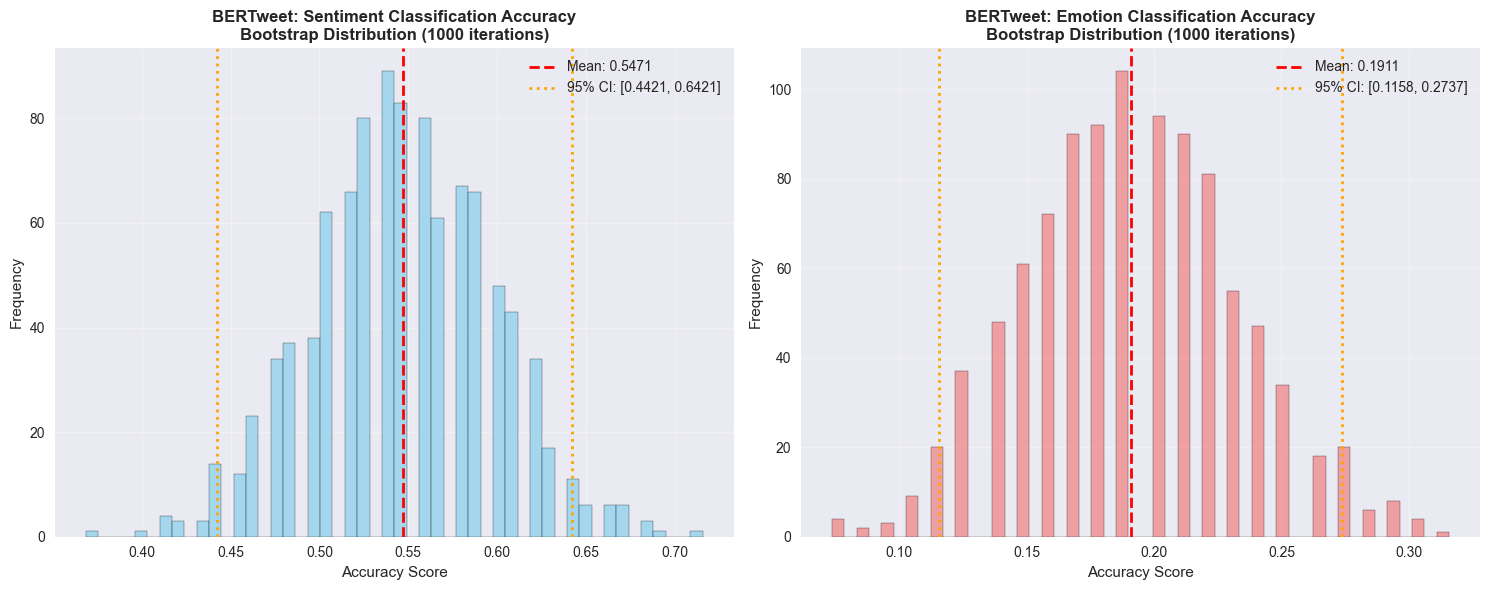

In [21]:
# Cell 7: Create Histograms - Figure 1 (Accuracy Distributions)
plt.figure(figsize=(15, 6))

# Subplot 1: Sentiment Accuracy
plt.subplot(1, 2, 1)
sentiment_acc_values = bootstrap_stats['sentiment_accuracy']['values']
plt.hist(sentiment_acc_values, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(bootstrap_stats['sentiment_accuracy']['mean'], color='red', linestyle='--', linewidth=2, 
           label=f"Mean: {bootstrap_stats['sentiment_accuracy']['mean']:.4f}")
plt.axvline(bootstrap_stats['sentiment_accuracy']['ci_lower'], color='orange', linestyle=':', linewidth=2,
           label=f"95% CI: [{bootstrap_stats['sentiment_accuracy']['ci_lower']:.4f}, {bootstrap_stats['sentiment_accuracy']['ci_upper']:.4f}]")
plt.axvline(bootstrap_stats['sentiment_accuracy']['ci_upper'], color='orange', linestyle=':', linewidth=2)
plt.xlabel('Accuracy Score')
plt.ylabel('Frequency')
plt.title('BERTweet: Sentiment Classification Accuracy\nBootstrap Distribution (1000 iterations)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Emotion Accuracy
plt.subplot(1, 2, 2)
emotion_acc_values = bootstrap_stats['emotion_accuracy']['values']
plt.hist(emotion_acc_values, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.axvline(bootstrap_stats['emotion_accuracy']['mean'], color='red', linestyle='--', linewidth=2,
           label=f"Mean: {bootstrap_stats['emotion_accuracy']['mean']:.4f}")
plt.axvline(bootstrap_stats['emotion_accuracy']['ci_lower'], color='orange', linestyle=':', linewidth=2,
           label=f"95% CI: [{bootstrap_stats['emotion_accuracy']['ci_lower']:.4f}, {bootstrap_stats['emotion_accuracy']['ci_upper']:.4f}]")
plt.axvline(bootstrap_stats['emotion_accuracy']['ci_upper'], color='orange', linestyle=':', linewidth=2)
plt.xlabel('Accuracy Score')
plt.ylabel('Frequency')
plt.title('BERTweet: Emotion Classification Accuracy\nBootstrap Distribution (1000 iterations)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bertweet_bootstrap_accuracy_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

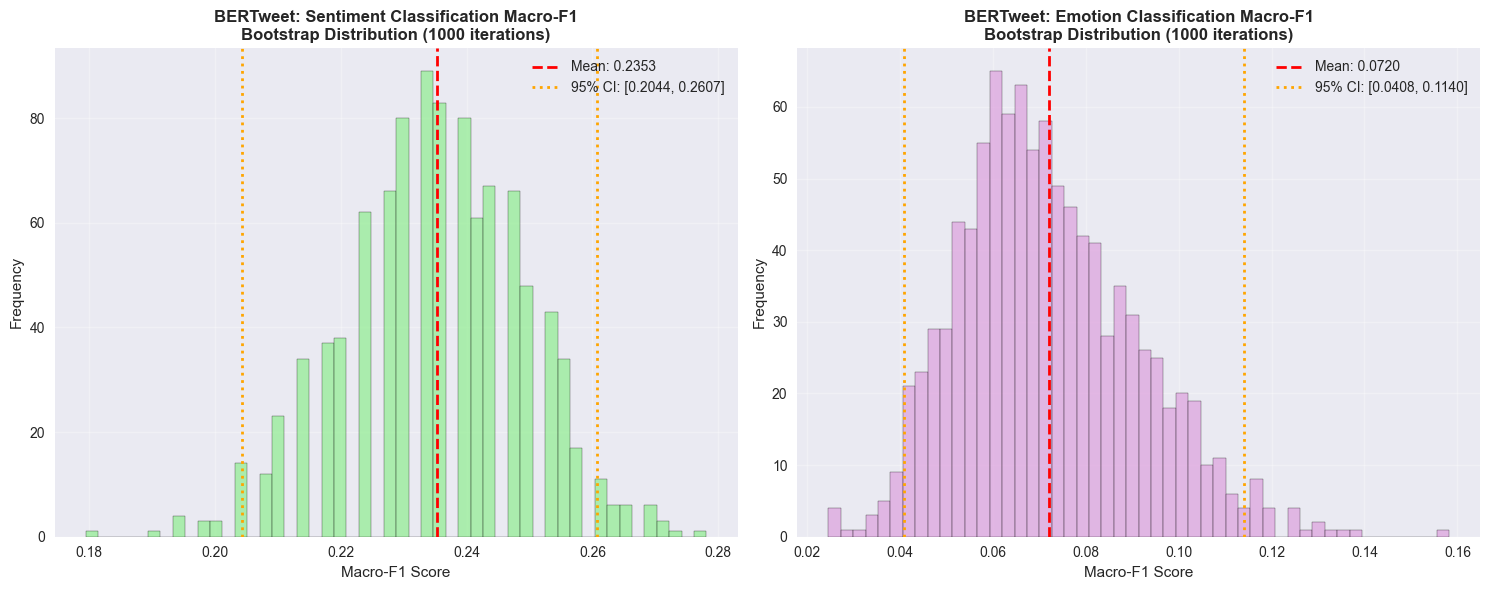

In [22]:
# Cell 8: Create Histograms - Figure 2 (Macro-F1 Distributions)
plt.figure(figsize=(15, 6))

# Subplot 1: Sentiment Macro-F1
plt.subplot(1, 2, 1)
sentiment_f1_values = bootstrap_stats['sentiment_f1']['values']
plt.hist(sentiment_f1_values, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.axvline(bootstrap_stats['sentiment_f1']['mean'], color='red', linestyle='--', linewidth=2,
           label=f"Mean: {bootstrap_stats['sentiment_f1']['mean']:.4f}")
plt.axvline(bootstrap_stats['sentiment_f1']['ci_lower'], color='orange', linestyle=':', linewidth=2,
           label=f"95% CI: [{bootstrap_stats['sentiment_f1']['ci_lower']:.4f}, {bootstrap_stats['sentiment_f1']['ci_upper']:.4f}]")
plt.axvline(bootstrap_stats['sentiment_f1']['ci_upper'], color='orange', linestyle=':', linewidth=2)
plt.xlabel('Macro-F1 Score')
plt.ylabel('Frequency')
plt.title('BERTweet: Sentiment Classification Macro-F1\nBootstrap Distribution (1000 iterations)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Emotion Macro-F1
plt.subplot(1, 2, 2)
emotion_f1_values = bootstrap_stats['emotion_f1']['values']
plt.hist(emotion_f1_values, bins=50, alpha=0.7, color='plum', edgecolor='black')
plt.axvline(bootstrap_stats['emotion_f1']['mean'], color='red', linestyle='--', linewidth=2,
           label=f"Mean: {bootstrap_stats['emotion_f1']['mean']:.4f}")
plt.axvline(bootstrap_stats['emotion_f1']['ci_lower'], color='orange', linestyle=':', linewidth=2,
           label=f"95% CI: [{bootstrap_stats['emotion_f1']['ci_lower']:.4f}, {bootstrap_stats['emotion_f1']['ci_upper']:.4f}]")
plt.axvline(bootstrap_stats['emotion_f1']['ci_upper'], color='orange', linestyle=':', linewidth=2)
plt.xlabel('Macro-F1 Score')
plt.ylabel('Frequency')
plt.title('BERTweet: Emotion Classification Macro-F1\nBootstrap Distribution (1000 iterations)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bertweet_bootstrap_f1_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
# Cell 9: Save Bootstrap Results and Generate Summary Report
import json
from datetime import datetime

def save_bootstrap_results(bootstrap_stats, model_name="BERTweet"):
    """Save bootstrap results to files"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Prepare serializable results
    serializable_results = {}
    for metric_name, stats in bootstrap_stats.items():
        serializable_results[metric_name] = {
            'mean': float(stats['mean']),
            'std': float(stats['std']),
            'ci_lower': float(stats['ci_lower']),
            'ci_upper': float(stats['ci_upper']),
            'values': [float(x) for x in stats['values']]
        }
    
    # Save detailed results
    results_file = f"bertweet_bootstrap_results_{timestamp}.json"
    with open(results_file, 'w') as f:
        json.dump(serializable_results, f, indent=2)
    
    # Create summary report
    summary_file = f"bertweet_bootstrap_summary_{timestamp}.txt"
    with open(summary_file, 'w') as f:
        f.write(f"{model_name} Bootstrap Analysis Summary Report\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Bootstrap Iterations: 1000\n")
        f.write(f"Sample Size per Iteration: 95\n")
        f.write(f"Total Dataset Size: 95\n\n")
        
        f.write("PERFORMANCE METRICS (Mean ± Std)\n")
        f.write("-" * 40 + "\n\n")
        
        for metric_name, stats in bootstrap_stats.items():
            task, measure = metric_name.split('_')
            f.write(f"{task.upper()} {measure.upper()}:\n")
            f.write(f"  Mean: {stats['mean']:.4f}\n")
            f.write(f"  Std:  {stats['std']:.4f}\n")
            f.write(f"  95% CI: [{stats['ci_lower']:.4f}, {stats['ci_upper']:.4f}]\n\n")
        
        f.write("KEY FINDINGS:\n")
        f.write("-" * 20 + "\n")
        
        # Calculate coefficient of variation for stability assessment
        sent_acc_cv = bootstrap_stats['sentiment_accuracy']['std'] / bootstrap_stats['sentiment_accuracy']['mean']
        sent_f1_cv = bootstrap_stats['sentiment_f1']['std'] / bootstrap_stats['sentiment_f1']['mean']
        emot_acc_cv = bootstrap_stats['emotion_accuracy']['std'] / bootstrap_stats['emotion_accuracy']['mean']
        emot_f1_cv = bootstrap_stats['emotion_f1']['std'] / bootstrap_stats['emotion_f1']['mean']
        
        f.write(f"1. Stability Assessment (Coefficient of Variation):\n")
        f.write(f"   - Sentiment Accuracy CV: {sent_acc_cv:.4f}\n")
        f.write(f"   - Sentiment F1 CV: {sent_f1_cv:.4f}\n")
        f.write(f"   - Emotion Accuracy CV: {emot_acc_cv:.4f}\n")
        f.write(f"   - Emotion F1 CV: {emot_f1_cv:.4f}\n\n")
        
        f.write(f"2. Best Performing Task:\n")
        if bootstrap_stats['sentiment_f1']['mean'] > bootstrap_stats['emotion_f1']['mean']:
            f.write(f"   - Sentiment classification (F1: {bootstrap_stats['sentiment_f1']['mean']:.4f})\n")
        else:
            f.write(f"   - Emotion classification (F1: {bootstrap_stats['emotion_f1']['mean']:.4f})\n")
        
        f.write(f"\n3. Confidence Interval Widths:\n")
        for metric_name, stats in bootstrap_stats.items():
            ci_width = stats['ci_upper'] - stats['ci_lower']
            f.write(f"   - {metric_name}: {ci_width:.4f}\n")
    
    print(f"\n💾 Bootstrap results saved:")
    print(f"   Detailed results: {results_file}")
    print(f"   Summary report: {summary_file}")
    
    return results_file, summary_file

# Save results
results_file, summary_file = save_bootstrap_results(bootstrap_stats, "BERTweet")

print("\n🎉 Bootstrap Analysis Complete!")
print("=" * 50)
print("📊 Final Summary:")
for metric_name, stats in bootstrap_stats.items():
    task, measure = metric_name.split('_')
    print(f"   {task.title()} {measure.title()}: {stats['mean']:.4f} ± {stats['std']:.4f}")


💾 Bootstrap results saved:
   Detailed results: bertweet_bootstrap_results_20250715_164708.json
   Summary report: bertweet_bootstrap_summary_20250715_164708.txt

🎉 Bootstrap Analysis Complete!
📊 Final Summary:
   Sentiment Accuracy: 0.5471 ± 0.0508
   Sentiment F1: 0.2353 ± 0.0142
   Emotion Accuracy: 0.1911 ± 0.0416
   Emotion F1: 0.0720 ± 0.0192
